In [1]:
#import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.optim as optim
import torch.nn.functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Adjusting the path variable
path = '/content/drive/My Drive/Autoencoders Assignment/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("cuda device not found.")

torch.Size([250, 250, 3])


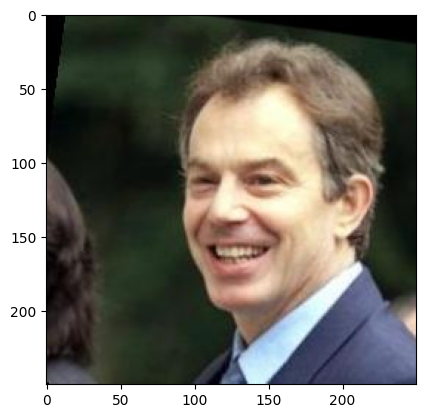

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

From the above image, Torch size is (250,250,3)-> This represents height and width of the image are 250px and number of channels are 3.

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

1. In terms of Applications:

$ Autoencoders (AEs):
- Data compression, denoising, and feature learning are the most common applications for AEs.
- They can be used for image reconstruction, dimensionality reduction, and unsupervised representation learning, among other things.

$ VAEs (Variational Autoencoders):
- VAEs are built for generative tasks and are especially useful for generating new data samples.
- They are commonly used in image generation, data synthesis, and the creation of continuous and structured latent spaces.

2. In terms of Architecture:

$ Autoencoders (AEs):
- AEs are networks that map input data to a latent space and then reconstruct the input from the latent representation.They have encoder and decoder to do this process.
- In traditional AEs, the latent space is typically a fixed, deterministic space.

$ Variational Autoencoders (VAEs):
- VAEs, like AEs, have also an encoder and a decoder, but they add a probabilistic interpretation of the latent space.
- The encoder produces a probability distribution (like Gaussian) over the latent space rather than a single point in the latent space.
- VAEs employ a sampling operation to introduce stochasticity during training and latent space sampling during generation.

3. In terms of loss function:

$ Autoencoders (AEs):
- A deterministic mapping from input to latent space and then to output is used by AEs. A reconstruction loss, such as mean squared error (MSE), is typically used to calculate the difference between the input and the reconstructed output.

$ Variational Autoencoders (VAEs):
- VAEs optimize a combination of a reconstruction loss and a regularization term using a probabilistic approach. The loss function is composed of two parts: a reconstruction loss (similar to AEs) and a KL divergence term that regularizes the latent space distribution.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #Encoder
        #Shape of input image 250*250*3, 256 is the number of hidden neurons in the first layer of the Neural Network(NN)
        self.fc1 = nn.Linear(250*250*3,256)
        #mean and latent variance of the latent space i.e., the bottleneck of the NN.
        #250 is the number of hidden neurons from the previous layer and 25 is the number of latent dimensions
        self.fc2_mean = nn.Linear(256, 25)
        self.fc2_log_var = nn.Linear(256, 25)

        #Decoder
        #reconstructing back to the original image
        self.fc3 = nn.Linear(25, 256)
        self.fc4 = nn.Linear(256,250*250*3)

    def encoder(self, x):
        #Flatten into a tensor
        x=x.view(x.size(0),-1)
        #Applying the first fully connected layer and ReLU activation
        h1 = F.relu(self.fc1(x))
        #Computing the mean and log variance of the latent space
        mean = self.fc2_mean(h1)
        log_var = self.fc2_log_var(h1)
        #Returning the mean and log variance
        return mean, log_var

    def decoder(self, z):
        #Applying the third fully connected layer and ReLU activation
        h2 = F.relu(self.fc3(z))
        #Reconstructing to original image with sigmoid activation function
        reconstruct = torch.sigmoid(self.fc4(h2))
        #Returning the reconstruct
        return reconstruct

    def reparameterize(self, mean, logvar):
        #Computing the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        #Generate a random sample from a normal distribution
        eps = torch.randn_like(std)
        #Reparameterization trick
        z = mean + eps * std
        #Returning reparameterization
        return z

    def forward(self, x):
        #Flatten the input tensor
        x=x.view(x.size(0),-1)
        #Pass the input through the encoder to obtain mean and logvar
        mean, logvar = self.encoder(x)
        #Reparameterize to obtain the latent variable
        z = self.reparameterize(mean, logvar)
        #Pass the latent variable through the decoder to obtain the reconstruction
        x_recon = self.decoder(z)
        #Return the reconstructed input, mean, and logvar
        return x_recon, mean, logvar

Key Terms:
- fc1 - First Fully Connected Layer
- fc2 - Second Fully Connected Layer
- fc3 - Third Fully Connected Layer
- fc4- Fourth Fully Connected Layer
- h1,h2 - Are hidden layers that allows to use activation functions

# The above code is the architecture of the VAE.
1. Encoder:
The encoder takes the input of size (250,250,3) i.e., 250*250 is height and width of the image and 3 is the number of channels. This encoder flattens the tensor i.e., it compresses and compute the mean and log variance of the latent space.

2. Decoder:
This reconstructs back to the original image by using sigmoid activation function respectively.

3. Forward:
- x = x.view(x.size(0), -1): This line flattens the input tensor, making it compatible with the fully connected layers in the encoder.
- mean, logvar = self.encoder(x): The flattened input is passed through the encoder to obtain the mean and log variance of the latent space.
- z = self.reparameterize(mean, logvar): The reparameterization trick is applied to obtain a sampled latent variable z based on the mean and log variance.
- x_recon = self.decoder(z): The sampled latent variable is then passed through the decoder to obtain the reconstructed input.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [8]:
#Create an instance of the VAE
model = VAE().to(device)

#iterate on the images
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

#Evaluation mode
model.eval()

#Processing a single image. I am considering the first image of the dataset here.
inputImage = images[0].unsqueeze(0)

In [9]:
# Pass the input image through the model
output, mean, logvar = model(inputImage)

# 1. Print the shape of the output of the encoder
print("Encoder Output Shape (mean latent):", mean.shape)
print("Encoder Output Shape (logvariance latent):", logvar.shape)

Encoder Output Shape (mean latent): torch.Size([1, 25])
Encoder Output Shape (logvariance latent): torch.Size([1, 25])


# Explanation:
- The shape of the encoder output represents the mean vector and log variance in the latent space.
- To generate new samples in the latent space, we would sample from a normal distribution using the mean and log variance (standard deviation) obtained from the encoder.

- Code Snippet for how I generated new samples in the latent space:

    std = torch.exp(0.5 * logvar)

    eps = torch.randn_like(std)

    z = mean + eps * std

1. std = torch.exp(0.5 * logvar):

    The standard deviation (std) is calculated from the log variance (logvar) by this line. The standard deviation represents the latent variable's spread or uncertainty.
2. eps = torch.randn_like(std):

    This line generates a tensor with random values sampled from a standard normal distribution with the same shape as std. torch.randn_like generates a tensor with random values sampled from a standard normal distribution with the same shape as std.
3. z = mean + eps * std:

    The reparameterization trick is used in this line, which transforms the sampled eps with the standard deviation std and adds the mean. During training, this step allows the model to backpropagate through the stochastic node (i.e., sampling operation).

  # Further Explanation Steps to Generate New Samples in Latent Space:
- Generate Random Latent Variable Samples:

    I must sample from a simple distribution to generate new samples in the latent space. The reparameterization trick is used to accomplish this. I sample from a standard normal distribution (N(0, 1)) and scale and shift the samples using the mean and standard deviation obtained from the encoder during training.

- Decode the Sampled Latent Variable:

    I used the sampled latent variable (z) to generate the corresponding output by passing it through the decoder.

- Visualization Processing:

    Data points generated can be visualized, analyzed, or used for subsequent tasks. It is critical to note that the generated samples should have properties similar to those found in the training data.

Following these steps allows me to use the previously learned latent space representations to generate new, plausible samples. The VAE's ability to map samples from a simple distribution to a more complex, meaningful distribution that captures the underlying structure of the input data is critical.




In [10]:
# 2. Use the decoder to create new images
# Generating a random latent vector for creating new samples
sample=model.reparameterize(mean, logvar)

# Passing the random latent vector through the decoder
generated_images = model.decoder(sample)

# Printing the shape of the output
print("Decoder Output Shape:", generated_images.shape)

Decoder Output Shape: torch.Size([1, 187500])


Decoder output is the same as original image size (250,250,3) i.e., 187500. So, I can come to the conclusion that the forward pass is working as expected.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.

In [11]:
#Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 96207262


* create an optimizer for training

In [12]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate
print(optim)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [13]:
reconstructed = generated_images.view(-1, 3, 250, 250)
# Reconstruction Loss
reconstruction_loss = F.binary_cross_entropy(reconstructed, inputImage, reduction='sum')

# KL Divergence Loss
kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

# Total loss of VAE
loss_function = reconstruction_loss + kl_divergence_loss

The loss function in training a Variational Autoencoder (VAE) typically consists of two main components: the reconstruction loss and the regularization term (KL divergence). Let's go over each term and its associated goal:

1. Reconstruction Loss:

    Goal: The reconstruction loss quantifies the difference between the input data and its reconstructed version. It ensures that the VAE can reconstruct the original input accurately, which encourages the model to learn meaningful representations.

    Explanation: The VAE learns to map input data to a latent space and back to the input space during training. Deviations between the original and reconstructed data are penalized by the reconstruction loss.
2. Regularization Term (KL Divergence):

    Goal: The goal of the regularization term, which is expressed as the Kullback-Leibler (KL) divergence, is to enforce a specific structure in the latent space. It encourages the learned distribution of the latent variables to resemble a predefined distribution, most commonly a standard normal distribution.

    Explanation: The VAE learns a smooth and structured representation by regularizing the latent space. During the generation process, this aids in the generation of meaningful samples. The KL divergence ensures that the latent space is statistically desirable.
3. Total Loss:

    Goal: The total loss is the sum of the reconstruction and regularization losses. It strikes a balance between precise reconstruction and a well-behaved latent space distribution.

    Explanation: During training, the total loss guides the optimization process. It aims to accurately reconstruct input data while also shaping a latent space suitable for generative tasks. A hyperparameter (often denoted as) that weighs the importance of the regularization term controls the balance.

4. Formula for the Total Loss:

    Total Loss = Reconstruction Loss + KL Divergence

    Each term in Formulae Represents:

    - Depending on the nature of the data, the reconstruction loss is typically calculated using Mean Squared Error (MSE) or Binary Cross-Entropy. In this, I used binary cross entropy.
    - The KL divergence term quantifies the difference between a learned distribution of latent variables and a predefined distribution (for example, a standard normal distribution).

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

The number of epochs in my model is 10. The loss decreased absolutely for each epoch.

If loss is not decreasing, then learning rate should be altered, adjust the batch size, ensure input data is normalized and scaled, implement early stopping based on the loss, expermient with different optimizers, and implement gradient clipping to prevent exploding gradients. In this ways, we can troubleshoot the model.

In [ ]:
# Number of training epochs
model=model.to(device)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    running_loss = 0.0
    for images, _ in dataloader:
        # Forward passing
        images = images.to(device)
        outputs = model(images)
        loss = loss_function(outputs, images)

        # Backward and optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()

        running_loss += loss.item()

    # Calculating average loss for each epoch
    average_loss = running_loss / len(dataloader)

    # Printing the average loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}')

Epoch 1, Loss: 0.0147
Epoch 2, Loss: 0.0050
Epoch 3, Loss: 0.0029
Epoch 4, Loss: 0.0022
Epoch 5, Loss: 0.0018
Epoch 6, Loss: 0.0016
Epoch 7, Loss: 0.0015
Epoch 8, Loss: 0.0015
Epoch 9, Loss: 0.0014
Epoch 10, Loss: 0.0013
Finished Training


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

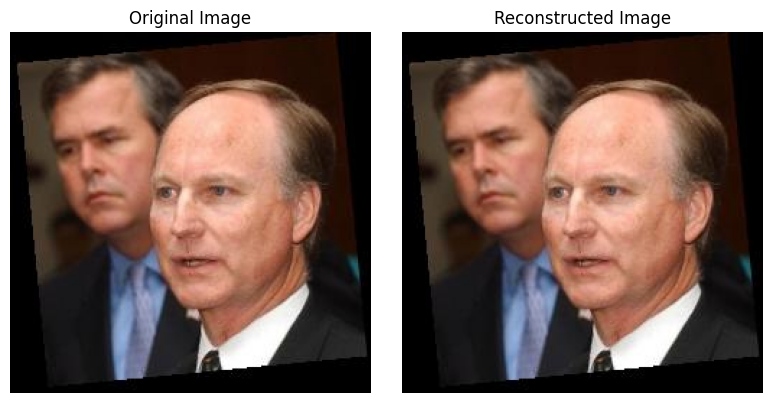

In [ ]:
# Setting the model to evaluation mode
model.eval()

# Getting a random image from the dataloader
random_index = random.randint(0, len(images) - 1)
random_image = images[random_index]

# Moving the image to the device
random_image = random_image.unsqueeze(0).to(device)

# Performing the forward pass to get the reconstructed image
reconstructed_image = model(random_image)

# Move the reconstructed image back to the CPU and remove the batch dimension
random_image = random_image.squeeze().cpu()
reconstructed_image = reconstructed_image.squeeze().cpu().detach()

# Plot the original and reconstructed images side by side
plt.figure(figsize=(8, 4))

# Plotting Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(random_image.permute(1, 2, 0))

# Plotting Reconstructed Image
plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image.permute(1, 2, 0))
plt.axis('off')

plt.show()